In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!git clone https://github.com/fastai/course-v3
%cd /content/course-v3/nbs/dl2
from exp.nb_08 import *

Cloning into 'course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.10 MiB | 37.55 MiB/s, done.
Resolving deltas: 100% (3251/3251), done.
/content/course-v3/nbs/dl2


In [ ]:
torch.optim

<module 'torch.optim' from '/usr/local/lib/python3.7/dist-packages/torch/optim/__init__.py'>

## Load dataset and vanila model

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 128
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=2)

nfs = [32, 64, 128, 256]

cbfs = [partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
learn, run= get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
model_summary(run, learn, data, True)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([256, 16, 128, 128])

Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([256, 32, 64, 64])

Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([256, 64, 32, 32])

Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([256, 32, 16, 16])

Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([256, 64, 8, 8])

Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([256, 128, 4, 4])

Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([256, 256, 2, 2])

Linear(in_features=256, out_features=10, bias=True)
torch.Size([256, 10])



In [ ]:
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([256, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([256, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([256, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([256, 32, 16, 16])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(

In [ ]:
run.fit(1, learn)

train: [1.7718690595627837, tensor(0.3763, device='cuda:0')]
valid: [1.6765175905652867, tensor(0.4372, device='cuda:0')]


---

## Refining the optimizer

In [ ]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)        
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        gps = []
        for pg, hyper in zip(self.param_groups, self.hypers):
            for p in pg:
                if p.grad is not None:
                    gps = gps + [(p, hyper)]
        return gps
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    def step(self):
        for p, hyper in grad_params:
            compose(p, self.steppers, **hyper)

In [ ]:
def sgd_step(p, lr, **kwargs):
    print(f"lr: {lr}\nkwargs: {kwargs}")
    # pytorch inplace function of sum. second parameter will be multiplied to first parameter
    p.data.add_(-lr, p.grad.data)
    return p
# steppers is compositional function
opt_func = partial(Optimizer, steppers=[sgd_step])

In [ ]:
Optimizer(learn.model.parameters(), sgd_step).param_groups[0].__len__()

23

qq: Can I get a pre-defined keyword parameter as an **kwargs?
this is because, as compose function only gets function and value, but sgd_step (which might be one of the compositional functions) requires lr parameter

In [ ]:
import inspect;print(inspect.getsource(compose))

def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x



In [ ]:
def getid(p, id, **kwargs): print(f"id: {id}", f"kwargs: {kwargs}")

def inner(p, **kwargs): getid(p, **kwargs)

inner(10, **{'lr':0.1, 'id':1234, 'name': 'Jessy'})

id: 1234 kwargs: {'lr': 0.1, 'name': 'Jessy'}


In [ ]:
def inner(p, **kwargs): print(f'id: {lr}')

inner(10, **{'lr':0.1, 'id':1234, 'name': 'Jessy'})

NameError: ignored

In [ ]:
dir(torch.optim)

- Q3

In [ ]:
# original one (i.e., dependency on pytorch)
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])

    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

In [5]:
# adjusted one
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lr  (self, pgid=-1): plt.plot(self.lrs)
    def plot_loss(self, skip_last=0): plt.plot(self.losses)

    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

In [ ]:
# original one
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs

    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)

    def begin_batch(self):
        if self.in_train: self.set_param()


In [6]:
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs): self.pname, self.sched_funcs = pname, listify(sched_funcs)

    def begin_batch(self):
        if not self.in_train: return
        fs = self.sched_funcs
        "I don't know why we should multiply(i.e., copy) the number of pg here when (only) the length is one"
        if len(fs) == 1:
            # print(f"before multiplying: {fs}")
            fs = fs * len(self.opt.param_groups)
            # print(f"after multiplying: {fs}")
        pos = self.n_epochs / self.epochs
        for f, h in zip(fs, self.opt.hypers):
            h[self.pname] = f(pos)

In [ ]:
learn.opt.param_groups.__len__()

1

In [ ]:
# original one

class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9

    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr

    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss


In [7]:
# adjusted one

class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
    
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        # New
        for pg in self.opt.hyper: pg['lr'] = lr
    
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

## Weight decay - AdamW

In [ ]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1-lr*wd)
    return p
weight_decay._defaults = dict({'wd':0.})

In [ ]:
def l2_reg(p, lr, wd, **kwargs):
    # p.g += lr*p
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict({'wd':0.})

In [ ]:
def sgd_step(p, lr, **kwargs):
    # pytorch inplace function of sum. second parameter will be multiplied to first parameter
    p.data.add_(-lr, p.grad.data)
    return p

- To see first layer output

```
learn.model[0]
param_groups[0].shape
xb, yb = next(iter(data.train_dl))
xb.shape
learn.model[0].forward(xb).shape
```

In [8]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)        
        self.param_groups = list(params)
        maybe_update(self.steppers, defaults, get_defaults)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        gps = []
        for pg, hyper in zip(self.param_groups, self.hypers):
            for p in pg:
                if p.grad is not None:
                    gps = gps + [(p, hyper)]
        return gps
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [9]:
def maybe_update(os, dest, f):
    for o in os:
        for k, v in f(o).items():
            if not k in dest: dest[k] = v
def get_defaults(o): return getattr(o, '_defaults', {})            

In [ ]:
sgd_opt = partial(Optimizer, steppers = [weight_decay,sgd_step])

In [ ]:
import inspect
inspect.getfullargspec(get_learn_run)

FullArgSpec(args=['nfs', 'data', 'lr', 'layer', 'cbs', 'opt_func'], varargs=None, varkw='kwargs', defaults=(None, None), kwonlyargs=[], kwonlydefaults=None, annotations={})

- I don't know how the length of parameter group gets bigger than 1.

### Decreading period - warm-up

train: [1.5161333405388637, tensor(0.4927, device='cuda:0')]
valid: [1.3695940734474523, tensor(0.5419, device='cuda:0')]


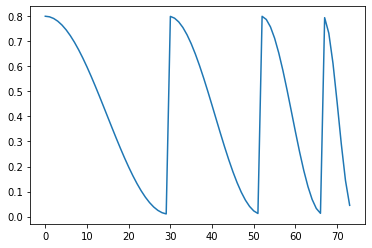

In [ ]:
sched = combine_scheds(torch.tensor([.4, .3, .2, .1]), [sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01)])
learn2, run2= get_learn_run(nfs, data, 0.4, conv_layer,
                          cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                          opt_func = sgd_opt)
run2.fit(1, learn)
run2.recorder.plot_lr()

### Increasing period - cool-down

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  This is separate from the ipykernel package so we can avoid doing imports until


train: [1.8977174282527194, tensor(0.3538, device='cuda:0')]
valid: [1.5409714619824841, tensor(0.4882, device='cuda:0')]


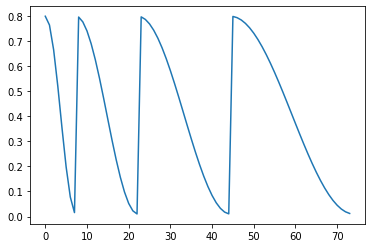

In [ ]:
sched = combine_scheds(torch.tensor([.1, .2, .3, .4]), [sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01)])
learn, run= get_learn_run(nfs, data, 0.4, conv_layer,
                          cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                          opt_func = sgd_opt)
run.fit(1, learn)
run.recorder.plot_lr()

Increasing V - better

---

- Plot (of x = lr, y = loss) will not work anymore as learning rate is not monotonic anymore.

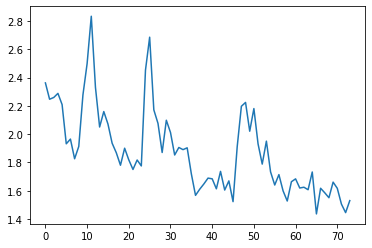

In [ ]:
run.recorder.plot_loss()

In [ ]:
??plt.cohere

In [ ]:
run.recorder.lrs

[0.7999999999999986,
 0.7649352649565506,
 0.6659666015287591,
 0.520665006985634,
 0.3548280135451531,
 0.19789866179127702,
 0.07773873639111195,
 0.015681708738105593,
 0.796800680823401,
 0.7774366130885061,
 0.7413540423452226,
 0.6901726980893149,
 0.6261901646271355,
 0.5522784006741055,
 0.47175537173419935,
 0.3882358165398238,
 0.30546875118357875,
 0.2271696384498305,
 0.15685310918775652,
 0.09767592570712469,
 0.05229434048008541,
 0.02274548883135119,
 0.010355911052700173,
 0.7974714376972254,
 0.7872545643638799,
 0.7693953700848708,
 0.7442510260712142,
 0.71232418473081,
 0.6742530765273979,
 0.6307989685380562,
 0.5828305605678792,
 0.5313069086245223,
 0.47725787699687683,
 0.4217643590967853,
 0.36593567870042853,
 0.3108879941874265,
 0.2577217187520159,
 0.20750005074764932,
 0.16122691281362544,
 0.11982747242279479,
 0.08412931975452298,
 0.05484603626275619,
 0.032563410180553864,
 0.01772674043297351,
 0.01063265551454784,
 0.7991993598788443,
 0.794318309034

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

dt = 0.01
t = np.arange(0, 30, dt)
nse1 = np.random.randn(len(t))                 # white noise 1
nse2 = np.random.randn(len(t))                 # white noise 2

# Two signals with a coherent part at 10Hz and a random part
s1 = np.sin(2 * np.pi * 10 * t) + nse1
s2 = np.sin(2 * np.pi * 10 * t) + nse2

fig, axs = plt.subplots(2, 2)


n = len(l1)

axs[0].plot(range(n), l1, range(n), l2)
# axs[0].set_xlim(0, 2)
axs[0].set_xlabel('loss')
axs[0].set_ylabel('inc and dec')
axs[0].grid(True)

# cxy, f = axs[1].cohere(l1, l2, 256, 1. / dt)
cxy, f = axs[1].cohere(l1, l2)
axs[1].set_ylabel('coherence')

fig.tight_layout()
plt.show()

In [ ]:
import inspect; inspect.getfullargspec(plt.plot)

FullArgSpec(args=[], varargs='args', varkw='kwargs', defaults=None, kwonlyargs=['scalex', 'scaley', 'data'], kwonlydefaults={'scalex': True, 'scaley': True, 'data': None}, annotations={})

In [ ]:
sched = combine_scheds(torch.tensor([.1, .2, .3, .4]), [sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01)])
learns, runs= get_learn_run(nfs, data, 0.4, conv_layer,
                          cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                          opt_func = sgd_opt)
runs.fit(1, learns)

sched = combine_scheds(torch.tensor([.4, .3, .2, .1]), [sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01)])
learnf, runf= get_learn_run(nfs, data, 0.4, conv_layer,
                          cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                          opt_func = sgd_opt)
runf.fit(1, learnf)

train: [1.8450042985663744, tensor(0.3712, device='cuda:0')]
valid: [1.4998996068869426, tensor(0.5075, device='cuda:0')]
train: [1.899878881085648, tensor(0.3506, device='cuda:0')]
valid: [1.6379510847929937, tensor(0.4380, device='cuda:0')]


Text(0.5, 0.98, 'warm-up(left) vs cool-down(right)')

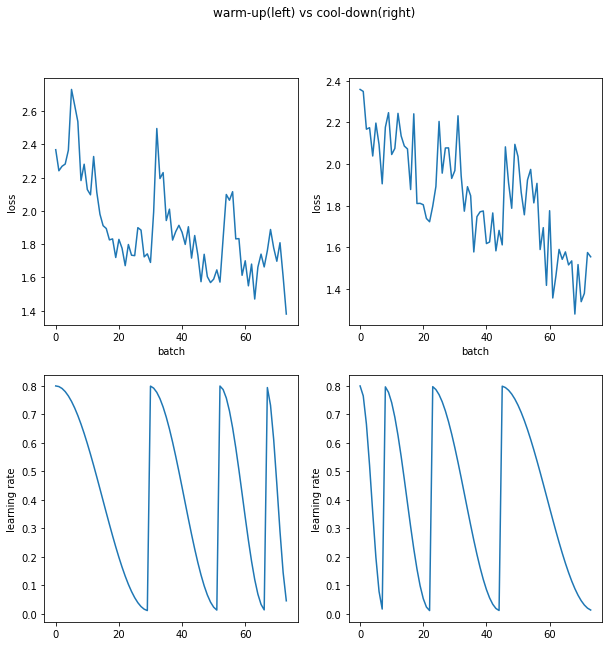

In [ ]:
# inspect.getfullargspec(plt.subplot)
fig, axs = plt.subplots(2,2, figsize=(10, 10))
for ax, r in zip(axs.transpose(), [runf, runs]):
    ax[0].plot([o.item() for o in r.recorder.losses])
    ax[1].plot(r.recorder.lrs)
    ax[0].set_xlabel('batch')
    ax[0].set_ylabel('loss')
    ax[1].set_ylabel('learning rate')
fig.suptitle("warm-up(left) vs cool-down(right)")

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

In [ ]:
learn.opt.hypers #TODO

[{'lr': 0.04506473956948709, 'wd': 0.0}]

- Let's calculate number of parameters quickly

In [ ]:
mps = [len(p.storage()) for p in learn.opt.param_groups[-1]]
f"Total parameters: {sum(mps)},\n parameter list: {mps}"

'Total parameters: 432730,\n parameter list: [432, 16, 16, 4608, 32, 32, 18432, 64, 64, 18432, 32, 32, 18432, 64, 64, 73728, 128, 128, 294912, 256, 256, 2560, 10]'

- Checking stride, storage, shape
```
p1, p2 = learn.opt.param_groups[-1][0], learn.opt.param_groups[-1][-2]
p1.shape, p2.shape
p1.stride(), p2.stride()
```

---

### Sum up and prove research paper result.
1. cosine annealing is affective. (warm-up, not cooling down)
2. l2 reg and wd are same when sgd
3. different when adam

- SGD optimizer, compare l2 reg and weight decay results

In [ ]:
sched = combine_scheds(torch.tensor([.4, .3, .2, .1]), [sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01)])
learn, run= get_learn_run(nfs, data, 0.4, conv_layer,
                          cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                          opt_func = sgd_opt)
run.fit(3, learn)

train: [1.873322651547154, tensor(0.3667, device='cuda:0')]
valid: [1.4833745521496815, tensor(0.5078, device='cuda:0')]
train: [1.4416723320836413, tensor(0.5205, device='cuda:0')]
valid: [1.3152269108280255, tensor(0.5631, device='cuda:0')]
train: [1.243772338519115, tensor(0.5894, device='cuda:0')]
valid: [1.2530140326433121, tensor(0.5847, device='cuda:0')]


In [ ]:
inspect.signature(Optimizer)

<Signature (params, steppers, **defaults)>

In [ ]:
sgd_l2_opt = partial(Optimizer, steppers=[l2_reg, sgd_step])

sched = combine_scheds(torch.tensor([.4, .3, .2, .1]), [sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01)])
learn, run= get_learn_run(nfs, data, 0.4, conv_layer,
                          cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                          opt_func = sgd_l2_opt)
run.fit(3, learn)

train: [1.7639181556262542, tensor(0.3997, device='cuda:0')]
valid: [1.3977649781050956, tensor(0.5432, device='cuda:0')]
train: [1.3841661152510825, tensor(0.5415, device='cuda:0')]
valid: [1.2659856439092356, tensor(0.5837, device='cuda:0')]
train: [1.1941233812308585, tensor(0.6096, device='cuda:0')]
valid: [1.24076271397293, tensor(0.5921, device='cuda:0')]


- Adding actual weight decay

- However, before that, let's check how customized optimizer initilized.

In [ ]:
sched = combine_scheds(torch.tensor([.4, .3, .2, .1]), [sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01)])
learn, run= get_learn_run(nfs, data, 0.4, conv_layer,
                          cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                          opt_func = sgd_opt)

In [ ]:
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])
opt = sgd_opt(learn.model.parameters())
opt.hypers

[{'wd': 0.0}]

In [ ]:
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])
opt = sgd_opt(learn.model.parameters(), lr=0.1)
opt.hypers

[{'lr': 0.1, 'wd': 0.0}]

In [ ]:
opt.hypers[0]['wd'] = 0.01
opt.hypers[0]['lr'] = 0.3

In [ ]:
opt.hypers

[{'lr': 0.3, 'wd': 0.01}]

- Finally let's see your optimizer works as you expected

In [ ]:
sgd_opt

functools.partial(<class '__main__.Optimizer'>, steppers=[<function weight_decay at 0x7efb144eca70>, <function sgd_step at 0x7efb144ecf80>])

In [ ]:
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

learn, run= get_learn_run(nfs, data, 0.4, conv_layer,
                          cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                          opt_func = partial(sgd_opt, wd=0.01))

run.fit(3, learn)

train: [1.8290756762197697, tensor(0.3685, device='cuda:0')]
valid: [1.4980415256767516, tensor(0.5101, device='cuda:0')]
train: [1.5446156743386312, tensor(0.4813, device='cuda:0')]
valid: [1.4488744028662421, tensor(0.5378, device='cuda:0')]
train: [1.4898702138227373, tensor(0.5029, device='cuda:0')]
valid: [1.5035726015127389, tensor(0.5340, device='cuda:0')]


- Checking which hyper-parameters are in optimizer
```
torch.optim.SGD(learn.model.parameters(), lr=0.3).state_dict()['param_groups'][-1].keys()
```
\> dict_keys(['lr', 'momentum', 'dampening', 'weight_decay', 'nesterov', 'params'])
```
torch.optim.Adam(learn.model.parameters(), lr=0.3).state_dict()['param_groups'][-1].keys()
```
\> dict_keys(['lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'params'])


# Momentum

In [ ]:
import inspect; print(inspect.getsource(maybe_update))

def maybe_update(os, dest, f):
    '''
    os: optimizers
    '''
    for o in os:
        for k, v in f(o).items():
            if not k in dest: dest[k] = v



In [11]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
    def step(self):
        for p, hyper in self.grad_params():
            # if state does not have p(parameter value) as its key, initialize
            if p not in self.state:
                self.state[p] = {}
                # if training is in the first batch, initialize parameter filled in zeros
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p] # state = {'grad_avg': torch.zeros_like(p.grad.data)}
            for stat in self.stats: state = stat.update(p, state, **hyper) # state = {'grad_avg': ((..... p-2.grad) * mom + p-1.grad) * mom + p.grad}
            compose(p, self.steppers, **state, **hyper) # update parameter, i.e., p+1 = p - p * wd - p.g * lr
            self.state[p] = state # assign state (i.e., update key as an updated parameter, value as an updated gradient)

In [10]:
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError

class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p):
        return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [12]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1-lr*wd)
    return p
weight_decay._defaults = dict({'wd':0.})

def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

### My Experiment

Q. Dampening, warm-up, wd

- with dampening, warm-up lr, weight decay = 0.01

In [ ]:
sched = combine_scheds(torch.tensor([.4, .3, .2, .1]), [sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01)])
sgd_mom_opt = partial(StatefulOptimizer, steppers = [momentum_step, weight_decay], stats=MyAverageGrad(), wd=0.01)
learn, run = get_learn_run(nfs, data, 0.3, conv_layer,
                           cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                           opt_func=sgd_mom_opt)
run.fit(10, learn)

- with dampening, warm-up lr, no weight decay|

In [ ]:
sched = combine_scheds(torch.tensor([.4, .3, .2, .1]), [sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01)])
sgd_mom_opt = partial(StatefulOptimizer, steppers = [momentum_step, weight_decay], stats=MyAverageGrad(), wd=0)
learn, run = get_learn_run(nfs, data, 0.3, conv_layer,
                           cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                           opt_func=sgd_mom_opt)
run.fit(10, learn)

- without dampening (just moving average), warm-up lr, wd = 0.01

In [ ]:
sgd_mom_opt = partial(StatefulOptimizer, steppers = [momentum_step, weight_decay], stats=AverageGrad(), wd=0.01)
learn, run = get_learn_run(nfs, data, 0.3, conv_layer,
                           cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                           opt_func=sgd_mom_opt)
run.fit(10, learn)

In [ ]:
learn.opt.state.__len__()

23

In [ ]:
for k, v in learn.opt.state.items(): print(type(k), type(v)); break

<class 'torch.nn.parameter.Parameter'> <class 'dict'>


In [ ]:
learn.opt.hypers

[{'lr': 0.3, 'mom': 0.9, 'wd': 0.01}]

---

---

### momentum experiments

In [ ]:
x = torch.linspace(-3, 3, 300)
y = torch.randn(300) + 0.7

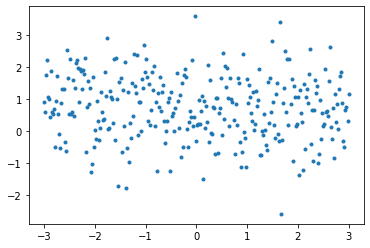

In [ ]:
plt.plot(x, y, linestyle='None', marker='.')

In [ ]:
y.mean(), y.std()

(tensor(0.7345), tensor(0.9861))

In [ ]:
beta = [0.01, 0.2, 0.5, 0.7, 0.9, 0.99]

In [ ]:
def plot_mom(f, title=''):
    fig, axes = plt.subplots(2,3, figsize=(25,15))
    for b, ax in zip(beta, axes.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg, result = 0, []
        for yi in y:
            avg = f(avg, b, yi)
            result.append(avg)
        ax.plot(result, color='red')
        ax.set_title(f"beta: {b}")
    fig.suptitle(f'{title}', fontsize=20)

In [ ]:
def mom1(avg, b, yi): return avg*b + yi

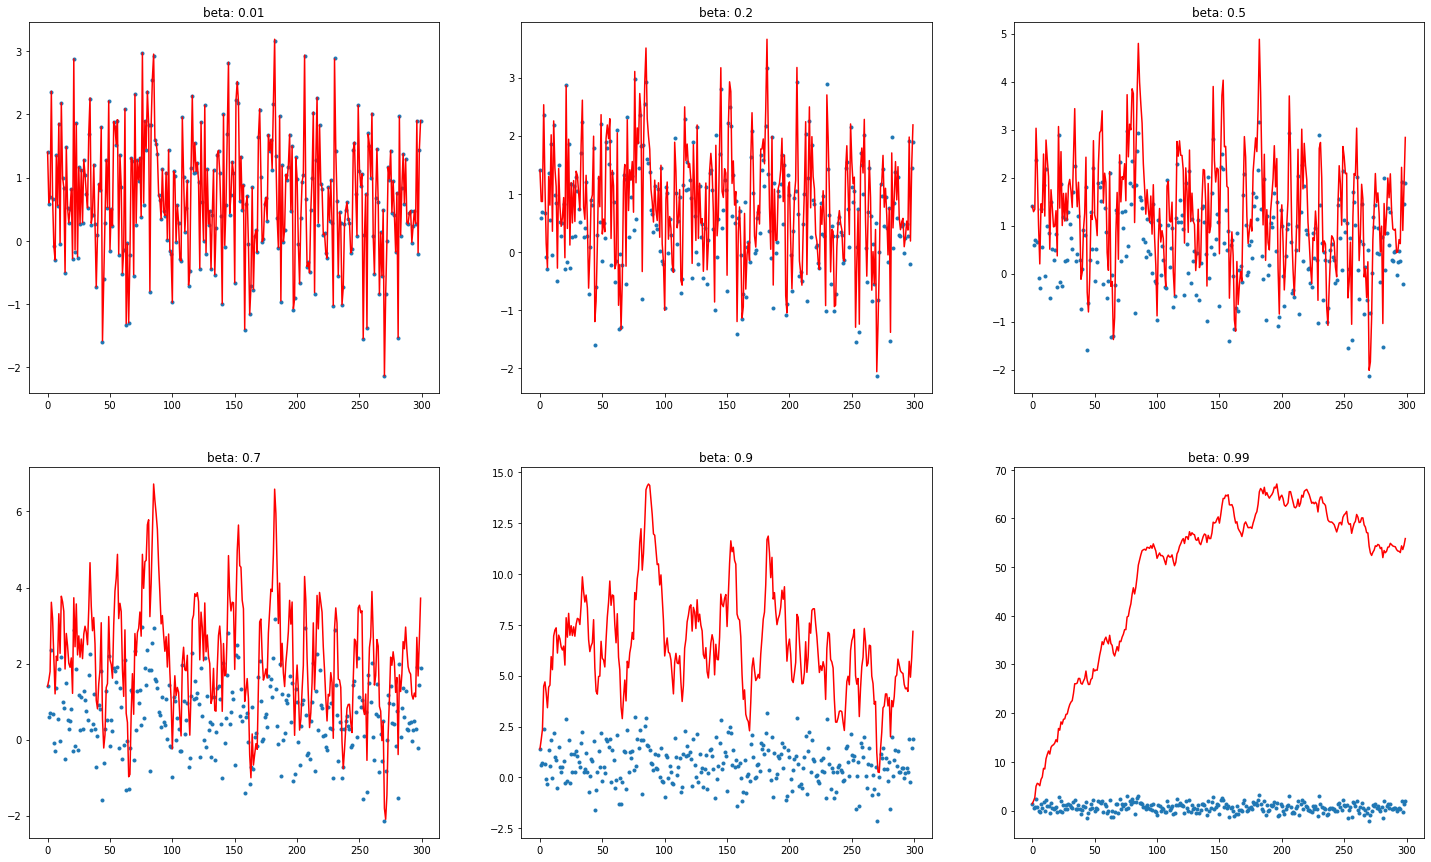

In [ ]:
plot_mom(mom1)

- what if .. I multiply (1-beta) to current one?

In [ ]:
def mom2(avg, b, yi): return avg*b + (1-b)*yi

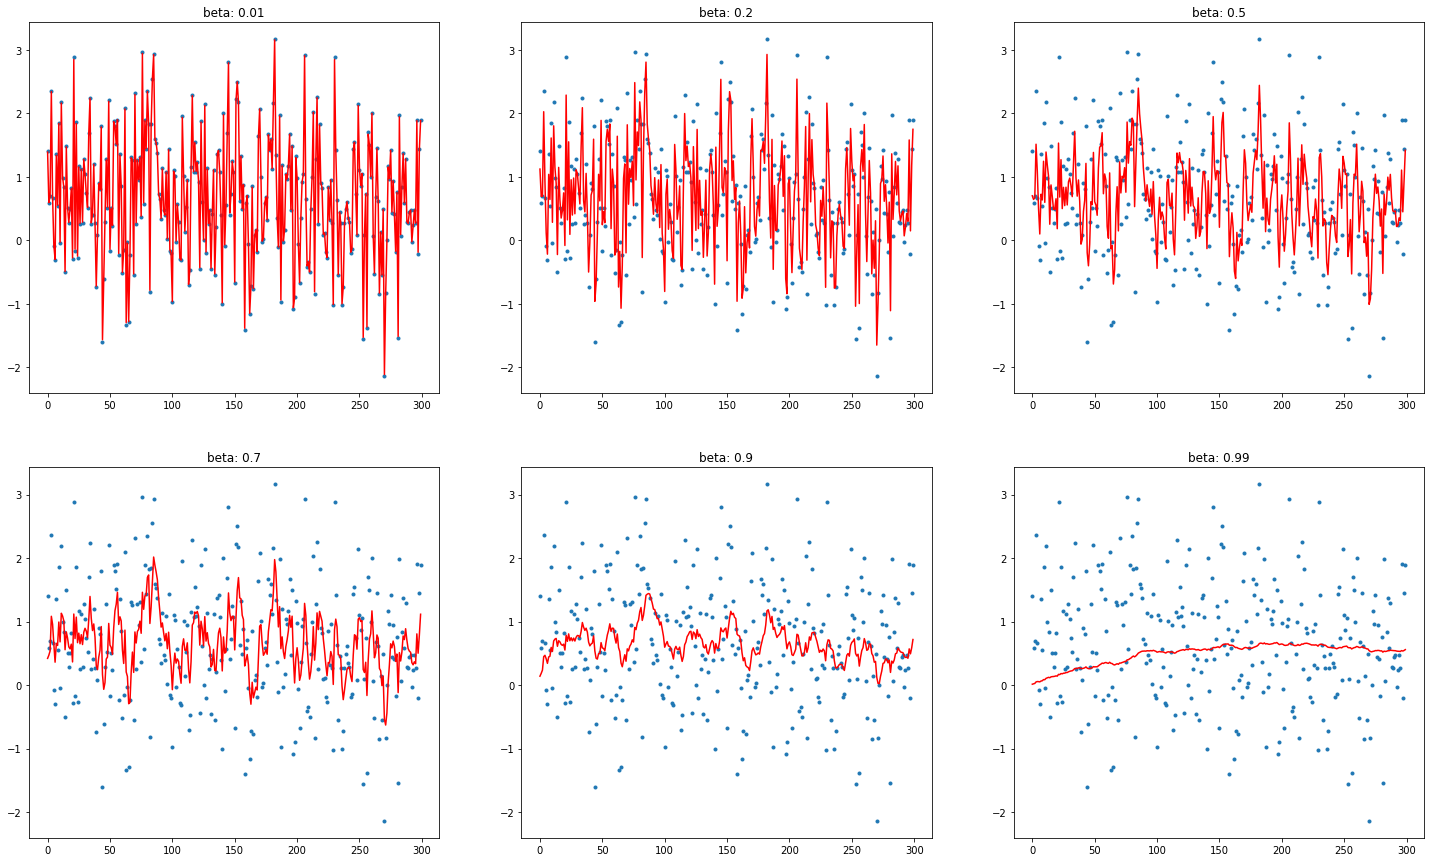

In [ ]:
plot_mom(mom2)

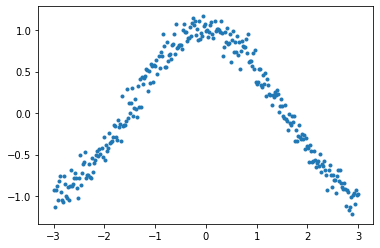

In [ ]:
y = torch.cos(x) + torch.randn(len(y)) * 0.1
plt.plot(x, y, linestyle='None', marker='.')

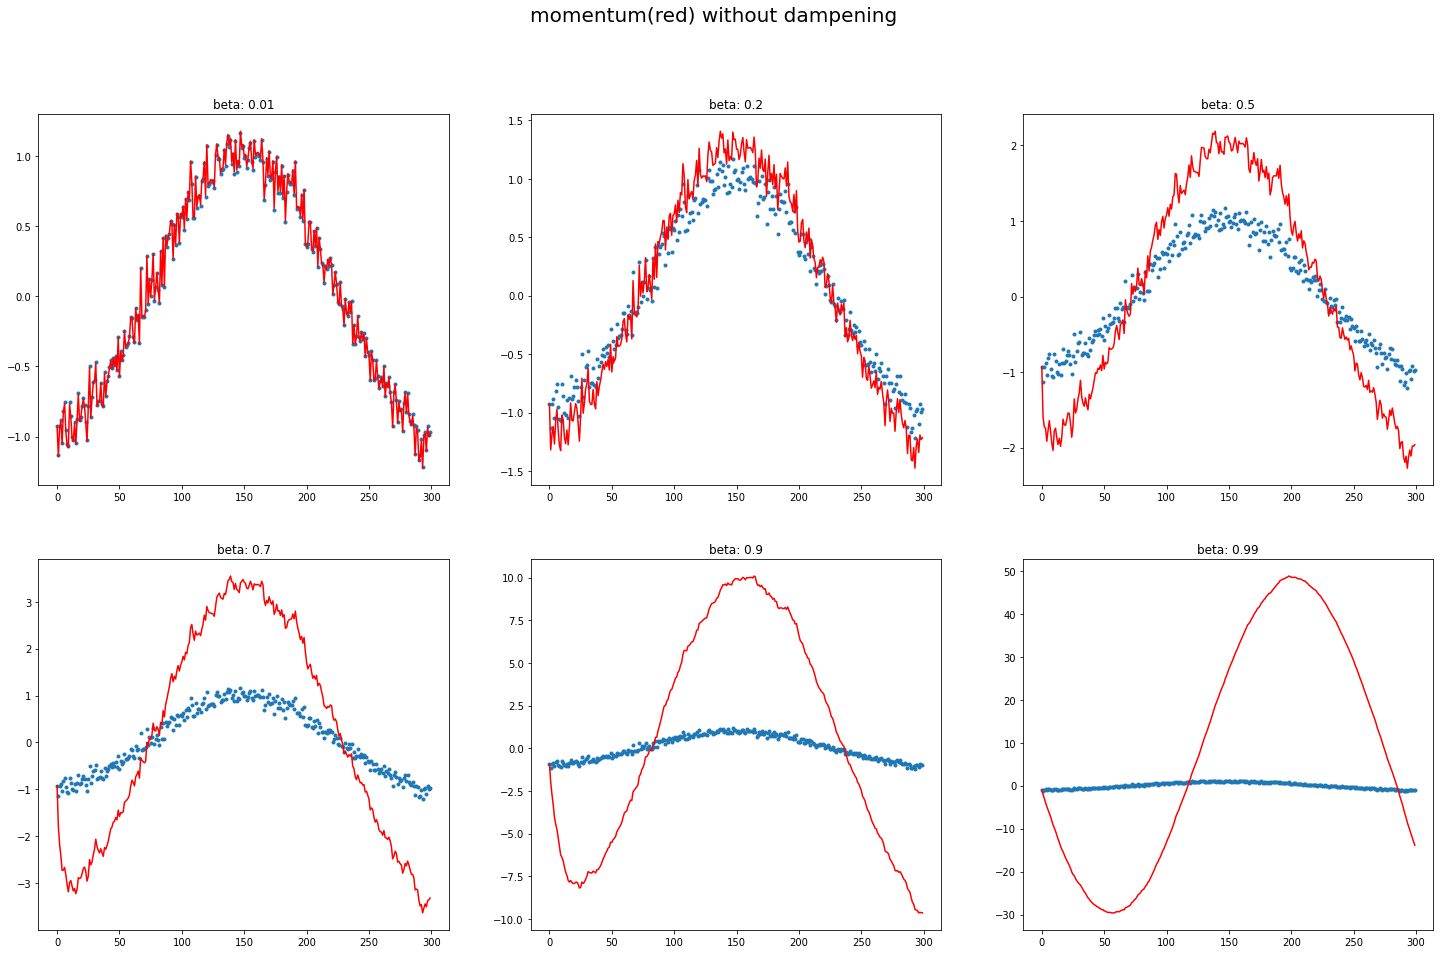

In [ ]:
plot_mom(mom1, 'momentum(red) without dampening')

without dampening, avg value follows the patter **way** slowly, **hyperbolic form**

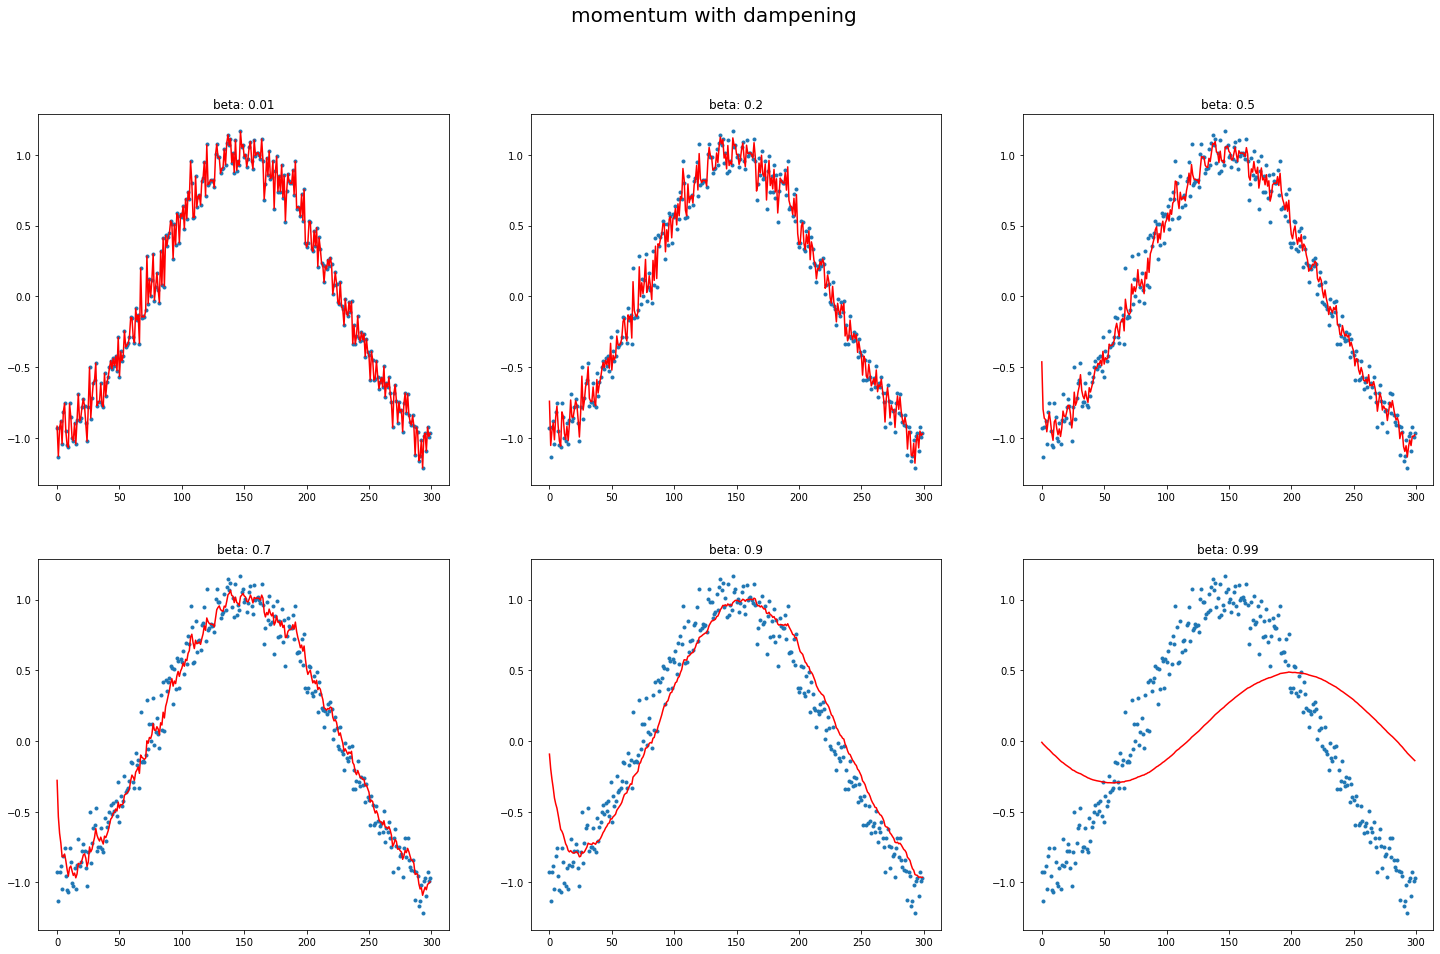

In [ ]:
plot_mom(mom2, 'momentum with dampening')

---

---

- Debiasing

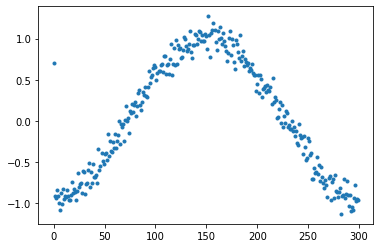

In [ ]:
x = torch.linspace(-3, 3, 300)
y = torch.cos(x) + torch.randn(len(x)) * 0.1
y[0] = 0.7
plt.plot(y, marker='.', linestyle='None')

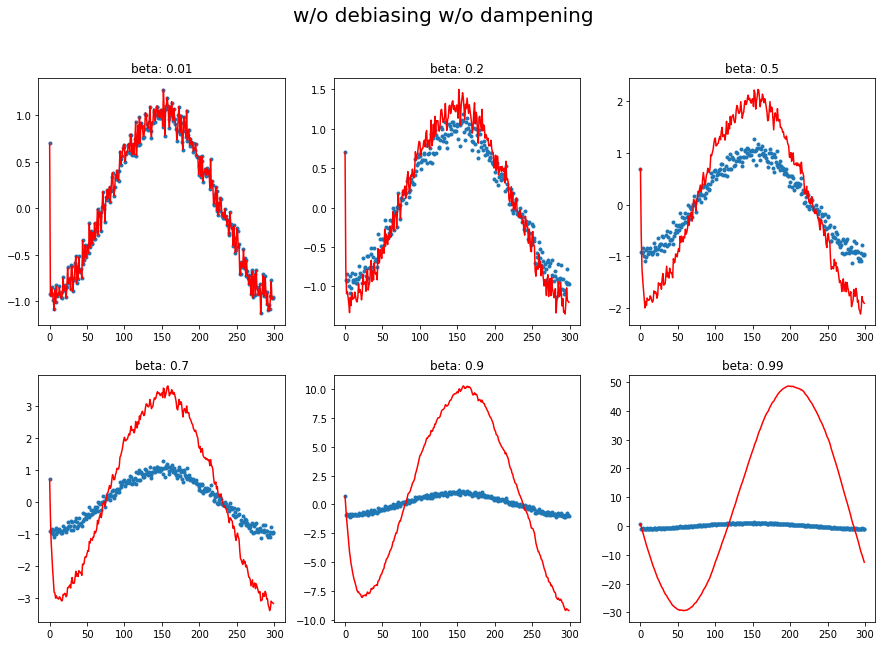

In [ ]:
def plot_mom(f, title=''):
    beta = [0.01, 0.2, 0.5, 0.7, 0.9, 0.99]
    fig, axes = plt.subplots(2,3, figsize=(15,10))
    for b, ax in zip(beta, axes.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg, result = 0, []
        for i, yi in enumerate(y):
            avg, res = f(avg, b, yi, i)
            result.append(res)
        ax.plot(result, color='red')
        ax.set_title(f"beta: {b}")
    fig.suptitle(f'{title}', fontsize=20)


def mom1(avg, b, yi, i):
    avg = (avg*b + yi)
    return avg, avg
plot_mom(mom1, 'w/o debiasing w/o dampening')

def mom2(avg, b, yi, i):
    avg = ((avg*b) + (1-b)*yi)
    return avg, avg

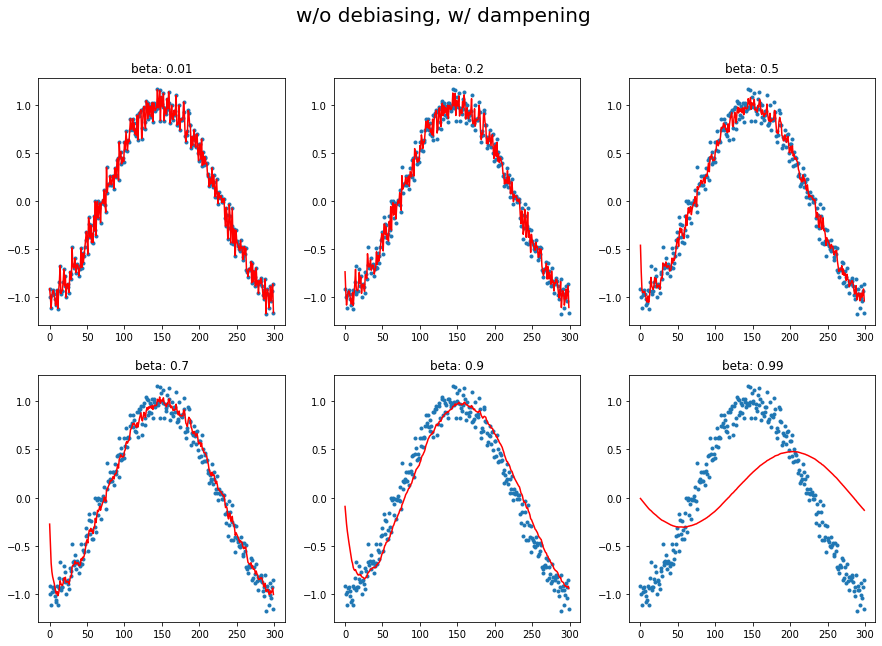

In [ ]:
plot_mom(mom2, 'w/o debiasing, w/ dampening')

- #with debiasing

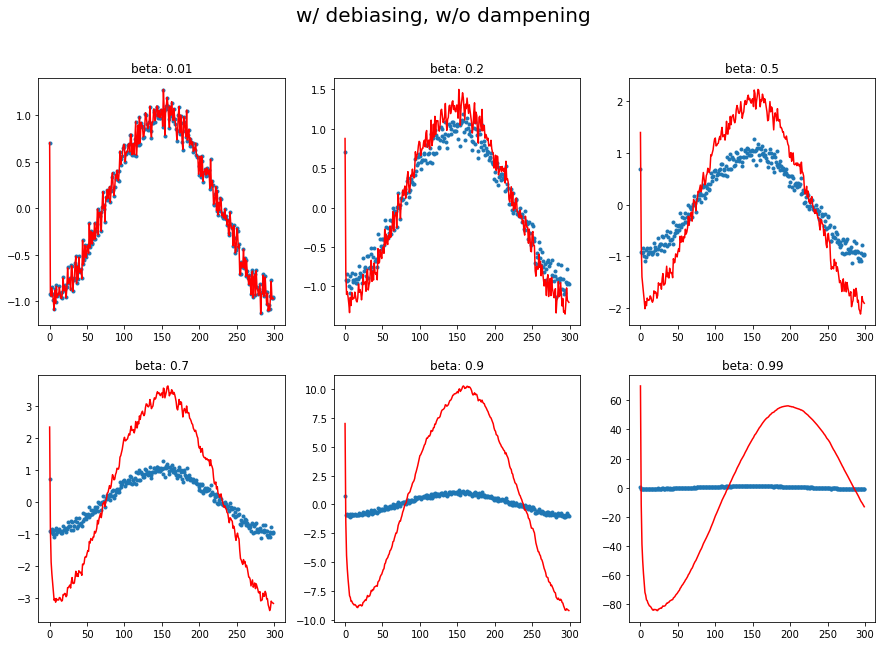

In [ ]:
def mom3(avg, b, yi, i):
    avg = (avg*b + yi)
    return avg, avg/(1-b**(i+1))
plot_mom(mom3, 'w/ debiasing, w/o dampening')

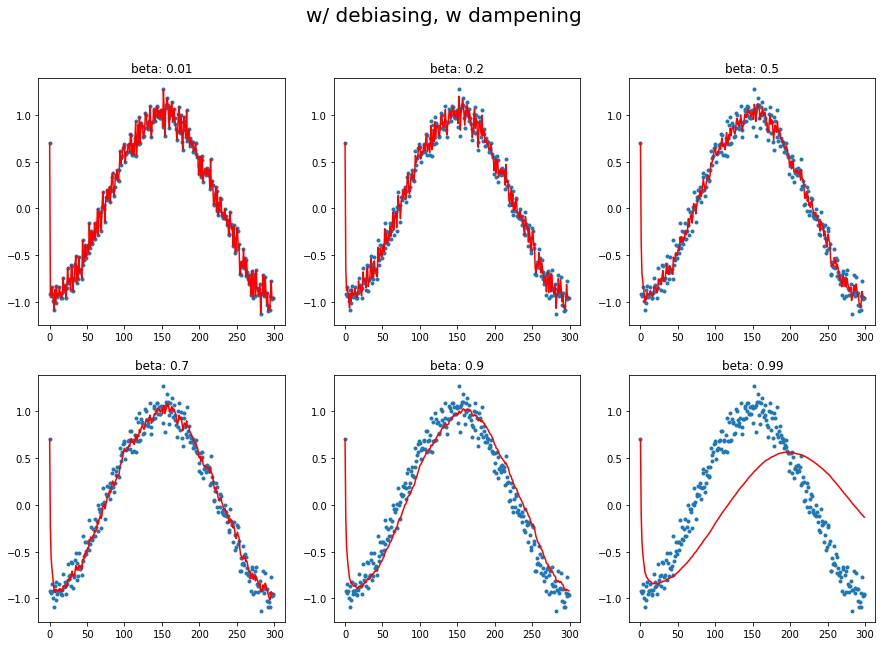

In [ ]:
def mom4(avg, b, yi, i):
    avg = ((avg*b) + (1-b)*yi)
    return avg, avg/(1-b**(i+1))

plot_mom(mom4, 'w/ debiasing, w dampening')    

# Adam and its friends

In [56]:
# for momentum
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def __init__(self, dampening=False): self.dampening=dampening

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state
# for stepsize - RMSProp
class AverageSqdGrad(Stat):
    _defaults = dict(sqr_mom=0.9)

    def __init__(self, dampening=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

class StepCount(Stat):
    def init_state(self, p): return {'step':0}
    def update(self, p, state, **kwargs):
        state['step'] +=1
        return state

def debias(mom, damp, step): return damp * (1-mom**step) / (1-mom)
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom    , mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt()+eps)
    return p
adam_step._defaults = dict(eps=1e-5)

def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer,
                   steppers=[adam_step, weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqdGrad(), StepCount()], **kwargs)

In [57]:
learn, run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func = adam_opt())
run.fit(3, learn)

train: [1.7320792685341642, tensor(0.3976, device='cuda:0')]
valid: [1.5125517515923568, tensor(0.4871, device='cuda:0')]
train: [1.2562112633989861, tensor(0.5852, device='cuda:0')]
valid: [1.3168852010350318, tensor(0.5666, device='cuda:0')]
train: [0.9474541513755412, tensor(0.6981, device='cuda:0')]
valid: [1.2992107882165604, tensor(0.5738, device='cuda:0')]
